### Inverse kinematics of `Panda`

In [1]:
import os,glfw
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mujoco_viewer
np.set_printoptions(precision=2,suppress=True,linewidth=100)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.2]


### Util

In [2]:
def r2w(R):
    """
        R to \omega
    """
    el = np.array([
            [R[2,1] - R[1,2]],
            [R[0,2] - R[2,0]], 
            [R[1,0] - R[0,1]]
        ])
    norm_el = np.linalg.norm(el)
    if norm_el > 1e-10:
        w = np.arctan2(norm_el, np.trace(R)-1) / norm_el * el
    elif R[0,0] > 0 and R[1,1] > 0 and R[2,2] > 0:
        w = np.array([[0, 0, 0]]).T
    else:
        w = np.math.pi/2 * np.array([[R[0,0]+1], [R[1,1]+1], [R[2,2]+1]])
    return w.flatten()

def trim_scale(x,th):
    """
        Trim scale
    """
    x         = np.copy(x)
    x_abs_max = np.abs(x).max()
    if x_abs_max > th:
        x = x*th/x_abs_max
    return x
print ("Ready.")

Ready.


### Parse `Panda`

In [3]:
xml_path='../model/panda/franka_panda.xml'
full_xml_path = os.path.abspath(os.path.join(os.getcwd(),xml_path))
model = mujoco.MjModel.from_xml_path(full_xml_path)
data = mujoco.MjData(model)
print ("[Panda] parsed.")

[Panda] parsed.


In [4]:
n_body          = model.nbody # number of bodies
body_names      = [mujoco.mj_id2name(model,mujoco.mjtObj.mjOBJ_BODY,x) for x in range(n_body)]
n_joint         = model.njnt     # number of joints
joint_names     = [mujoco.mj_id2name(model,mujoco.mjtJoint.mjJNT_HINGE,x) for x in range(n_joint)]
joint_types     = model.jnt_type # joint types
joint_ranges    = model.jnt_range # joint ranges
rev_joint_idxs  = np.where(joint_types==mujoco.mjtJoint.mjJNT_HINGE)[0].astype(np.int32)
rev_joint_names = [joint_names[x] for x in rev_joint_idxs]
n_rev_joint     = len(rev_joint_idxs)
rev_joint_min   = joint_ranges[rev_joint_idxs,0]
rev_joint_max   = joint_ranges[rev_joint_idxs,1]
rev_joint_range = rev_joint_max - rev_joint_min
pri_joint_idxs  = np.where(joint_types==mujoco.mjtJoint.mjJNT_SLIDE)[0].astype(np.int32)
pri_joint_names = [joint_names[x] for x in pri_joint_idxs]
n_pri_joint     = len(pri_joint_idxs)
# Print
print ("n_body:[%d]"%(n_body))
print ("body_names:%s"%(body_names))
print ("n_joint:[%d]"%(n_joint))
print ("joint_names:%s"%(joint_names))
print ("joint_types:%s"%(joint_types))
print ("joint_ranges:\n%s"%(joint_ranges))
print ("n_rev_joint:[%d]"%(n_rev_joint))
print ("rev_joint_idxs:%s"%(rev_joint_idxs))
print ("rev_joint_names:%s"%(rev_joint_names))
print ("rev_joint_min:%s"%(rev_joint_min))
print ("rev_joint_max:%s"%(rev_joint_max))
print ("rev_joint_range:%s"%(rev_joint_range))
print ("n_pri_joint:[%d]"%(n_pri_joint))
print ("pri_joint_idxs:%s"%(pri_joint_idxs))
print ("pri_joint_names:%s"%(pri_joint_names))

n_body:[18]
body_names:['world', 'panda_base', 'panda_pedestal', 'panda_link_0', 'panda_link_1', 'panda_link_2', 'panda_link_3', 'panda_link_4', 'panda_link_5', 'panda_link_6', 'panda_link_7', 'right_hand', 'panda_right_gripper', 'panda_eef', 'panda_leftfinger', 'panda_finger_joint1_tip', 'panda_rightfinger', 'panda_finger_joint2_tip']
n_joint:[9]
joint_names:['panda_joint1', 'panda_joint2', 'panda_joint3', 'panda_joint4', 'panda_joint5', 'panda_joint6', 'panda_joint7', 'panda_finger_joint1', 'panda_finger_joint2']
joint_types:[3 3 3 3 3 3 3 2 2]
joint_ranges:
[[-2.9   2.9 ]
 [-1.76  1.76]
 [-2.9   2.9 ]
 [-3.07 -0.07]
 [-2.9   2.9 ]
 [-0.02  3.75]
 [-2.9   2.9 ]
 [ 0.    0.04]
 [-0.04  0.  ]]
n_rev_joint:[7]
rev_joint_idxs:[0 1 2 3 4 5 6]
rev_joint_names:['panda_joint1', 'panda_joint2', 'panda_joint3', 'panda_joint4', 'panda_joint5', 'panda_joint6', 'panda_joint7']
rev_joint_min:[-2.9  -1.76 -2.9  -3.07 -2.9  -0.02 -2.9 ]
rev_joint_max:[ 2.9   1.76  2.9  -0.07  2.9   3.75  2.9 ]
rev_j

### Util functions

In [11]:
def get_J_body(model,data,body_name,rev_joint_idxs=None):
    J_p = np.zeros((3,model.nv)) # nv: nDoF
    J_R = np.zeros((3,model.nv))
    mujoco.mj_jacBody(model,data,J_p,J_R,data.body(body_name).id)
    if rev_joint_idxs is not None:
        J_p = J_p[:,rev_joint_idxs]
        J_R = J_R[:,rev_joint_idxs]
    J_full = np.array(np.vstack([J_p,J_R]))
    return J_p,J_R,J_full
print ("Ready.")

Ready.


In [12]:
# Viewer
viewer = mujoco_viewer.MujocoViewer(model,data,mode='window',
    title='Panda in MuJoCo',width=1200,height=800,hide_menus=True)
viewer.cam.azimuth   = 80
viewer.cam.distance  = 4.0
viewer.cam.elevation = -30
viewer.cam.lookat = np.array([0,0,1.2])
# Simulate and render
mujoco.mj_resetData(model, data)
mujoco.mj_forward(model, data)
# Set IK target
body_name = 'panda_eef'
q = data.qpos[rev_joint_idxs]
p_EE   = data.body(body_name).xpos
R_EE   = data.body(body_name).xmat.reshape([3,3])
p_trgt = p_EE + np.array([0.5,0.0,-0.5])
R_trgt = R_EE
# Loop
max_tick = 100
ticks,err_list,qrevs = np.zeros(max_tick),np.zeros(max_tick),np.zeros((max_tick,n_rev_joint))
imgs,img_ticks = [],[]
for tick in range(max_tick):
    if viewer.is_alive:
        # Compute Jacobian matrices
        J_p,J_R,J_full = get_J_body(model,data,body_name,rev_joint_idxs=rev_joint_idxs)
        # Numerical IK
        p_curr = data.body(body_name).xpos
        R_curr = data.body(body_name).xmat.reshape([3,3])
        p_err  = (p_trgt-p_curr)
        R_err  = np.linalg.solve(R_curr,R_trgt)
        w_err  = R_curr @ r2w(R_err)
        # Compute dq
        J   = J_full
        err = np.concatenate((p_err,w_err))
        eps = 1e-6
        dq  = np.linalg.solve(a=(J.T@J)+eps*np.eye(J.shape[1]),b=J.T@err)
        dq  = trim_scale(x=dq,th=5.0*np.pi/180.0)
        # Update
        q = q + dq
        data.qpos[rev_joint_idxs] = q
        # FK
        mujoco.mj_forward(model,data)
        # Render
        viewer.add_marker(
            pos   = data.body(body_name).xpos,
            size  = [0.05,0.05,0.05],
            rgba  = [1,0,0,0.3],
            type  = mujoco.mjtGeom.mjGEOM_SPHERE,
            label = '')
        viewer.add_marker(
            pos   = p_trgt,
            size  = [0.05,0.05,0.05],
            rgba  = [0,0,1,0.3],
            type  = mujoco.mjtGeom.mjGEOM_SPHERE,
            label = '')
        viewer.render()
        # Append
        ticks[tick]    = tick
        err_list[tick] = np.linalg.norm(err)
        qrevs[tick,:]  = data.qpos[rev_joint_idxs]
    else: break # terminate if viewer is dead
    # Grab image
    if (tick % (max_tick//10)) == 0:
        img = np.zeros((viewer.viewport.height,viewer.viewport.width,3),dtype=np.uint8)
        mujoco.mjr_render(viewer.viewport, viewer.scn, viewer.ctx)
        mujoco.mjr_readPixels(img, None, viewer.viewport, viewer.ctx) # this makes a little delay
        img = np.flipud(img) # flip image
        imgs.append(img)
        img_ticks.append(tick)
print ("Done.")

Done.


In [13]:
# Close viewer
viewer.close()

### Plot IK error and joint trajectories

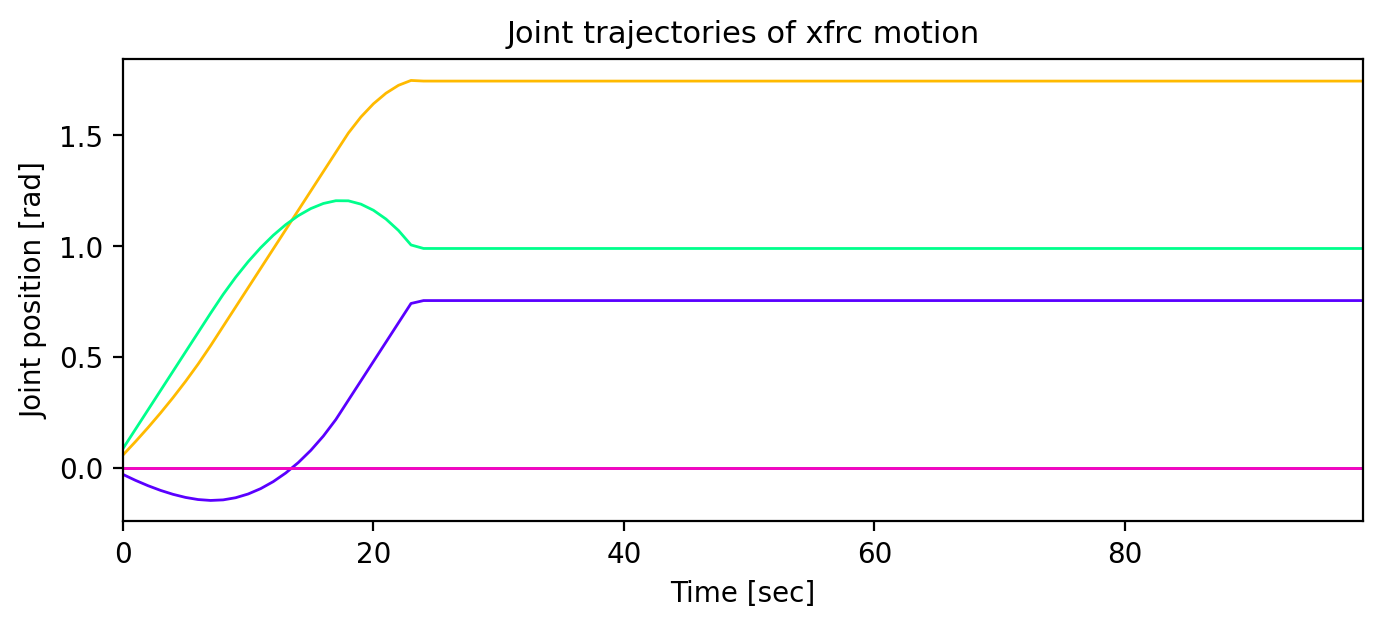

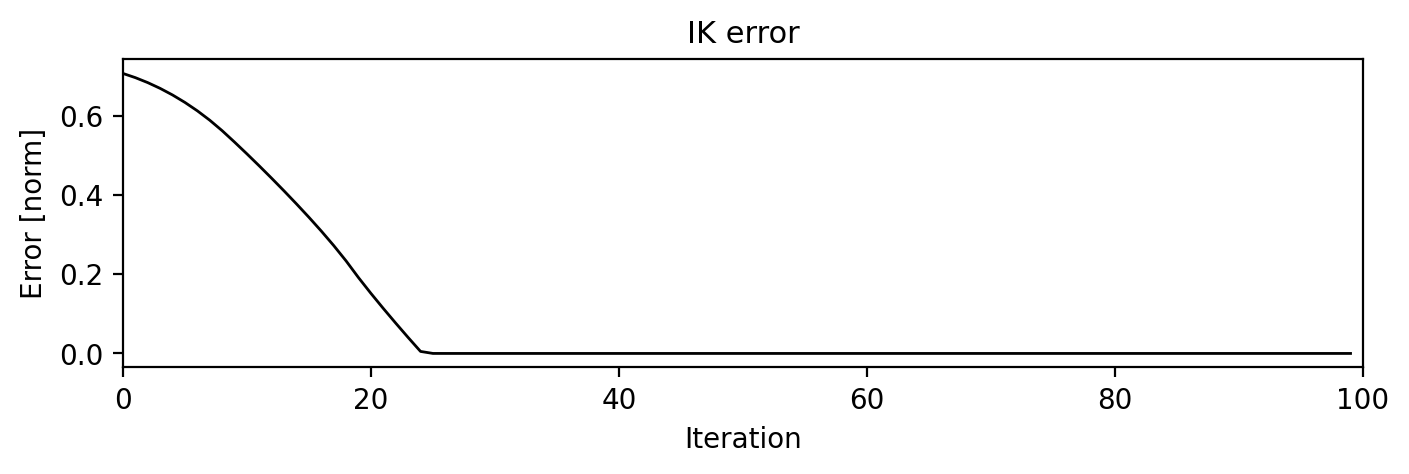

In [9]:
# Joint trajectories
cs = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_rev_joint)]
plt.figure(figsize=(8,3))
for j_idx in range(n_rev_joint):
    plt.plot(ticks,qrevs[:,j_idx],ls='-',color=cs[j_idx],lw=1)
plt.title('Joint trajectories of xfrc motion',fontsize=11)
plt.xlim(ticks[0],ticks[-1])
plt.xlabel('Time [sec]',fontsize=10)
plt.ylabel('Joint position [rad]',fontsize=10)
plt.show()
# Plot IK error
plt.figure(figsize=(8,2))
plt.plot(ticks,err_list,ls='-',color='k',lw=1)
plt.title('IK error',fontsize=11)
plt.xlabel('Iteration',fontsize=10)
plt.ylabel('Error [norm]',fontsize=10)
plt.xlim(0,max_tick)
plt.show()

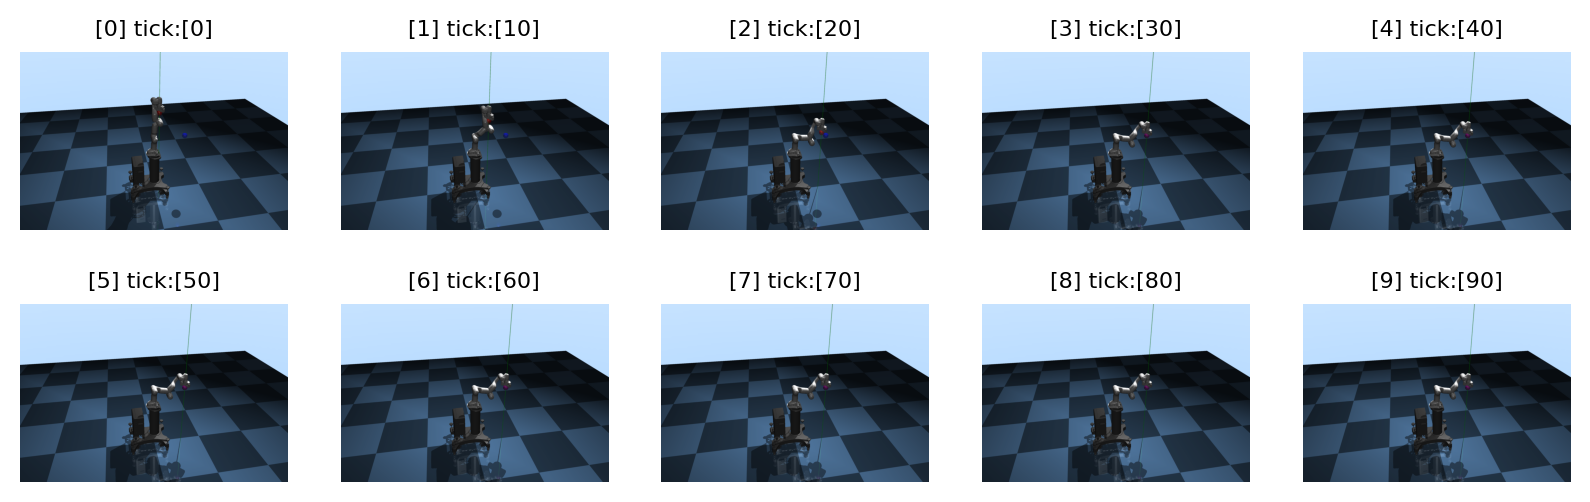

In [8]:
# Plot snapshots for Panda solving IK
fig = plt.figure(figsize=(10,3))
for i_idx,img in enumerate(imgs):
    ax = fig.add_subplot(2,5,i_idx+1)
    ax.imshow(img)
    ax.set_title('[%d] tick:[%d]'%(i_idx,img_ticks[i_idx]),fontsize=8)
    ax.axis('off')

### Augmented Jacobian Method